In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

from utils import *

# 1. Load data

In [2]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

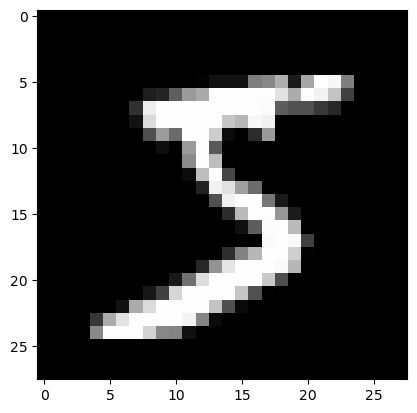

In [3]:
img, label = dataset[0]
plt.imshow(img[0], cmap='gray')

# 2. Model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
d_hidden = 500

class DenoisingAutoencoder(nn.Module):
    def __init__(self, d=d_hidden):
        super().__init__()
        self.d = d
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, self.d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        hidden = self.encoder(x)
        x = self.decoder(hidden)
        return hidden, x
    
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()

# 3. Training

epoch [1/20], loss:0.0930
epoch [2/20], loss:0.0790
epoch [3/20], loss:0.0740
epoch [4/20], loss:0.0709
epoch [5/20], loss:0.0674
epoch [6/20], loss:0.0685
epoch [7/20], loss:0.0644
epoch [8/20], loss:0.0608
epoch [9/20], loss:0.0649
epoch [10/20], loss:0.0685
epoch [11/20], loss:0.0653


/Users/cheung/Qingjiaoing/GNN and RL Course/VAE/utils.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 6))


epoch [12/20], loss:0.0625
epoch [13/20], loss:0.0628
epoch [14/20], loss:0.0627
epoch [15/20], loss:0.0580
epoch [16/20], loss:0.0603
epoch [17/20], loss:0.0620
epoch [18/20], loss:0.0578
epoch [19/20], loss:0.0570
epoch [20/20], loss:0.0575


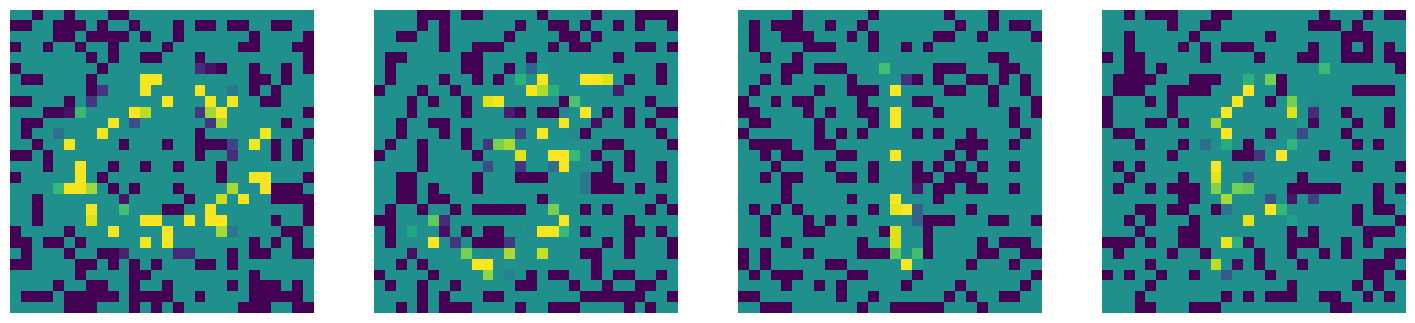

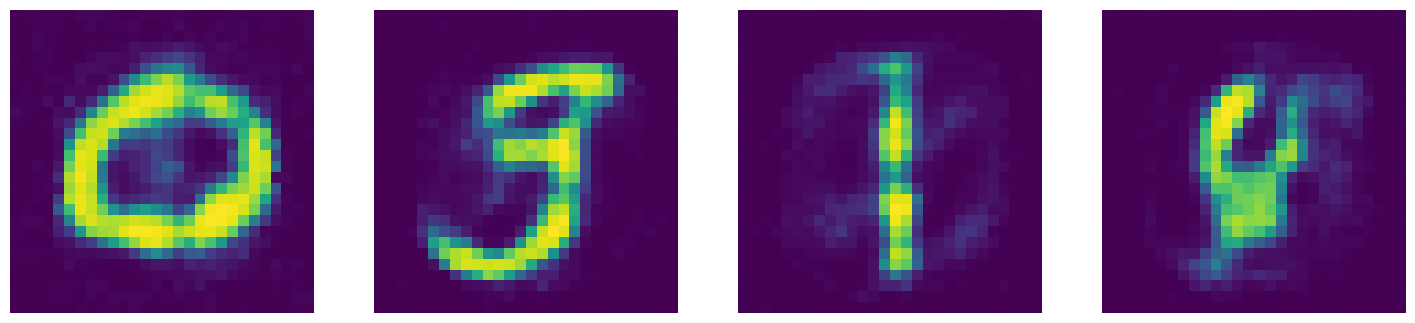

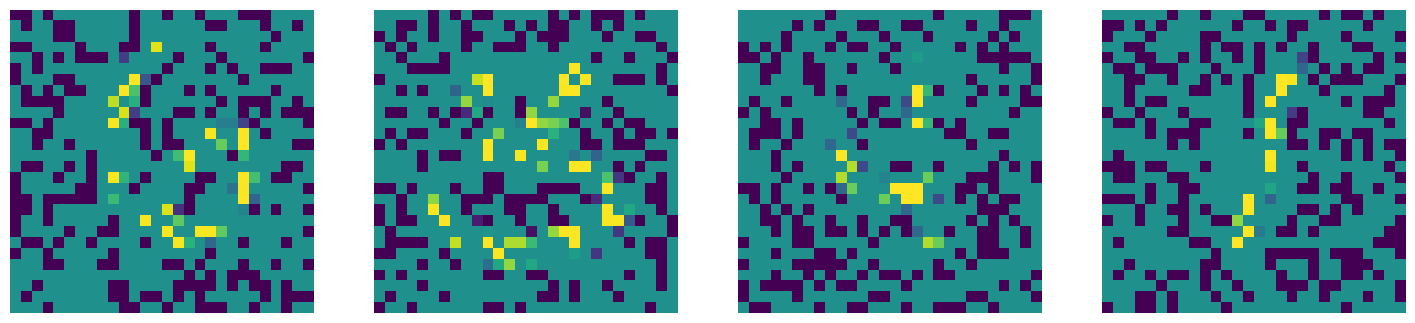

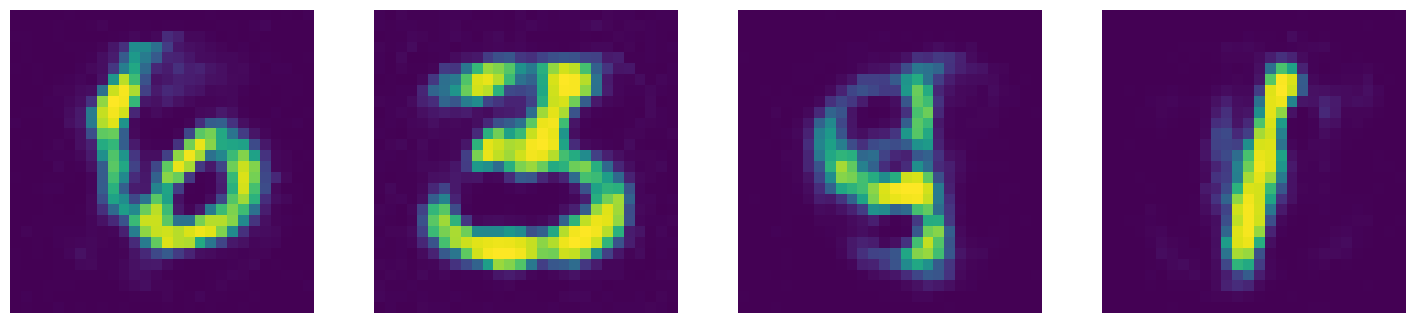

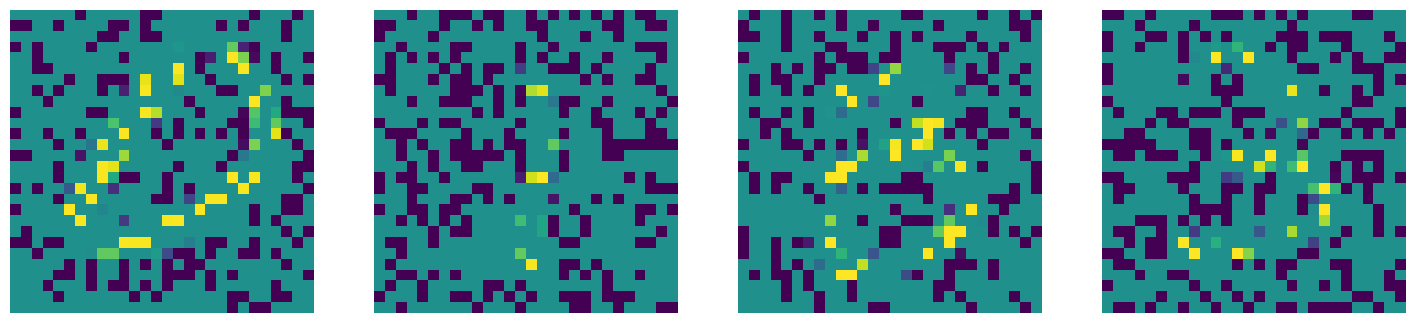

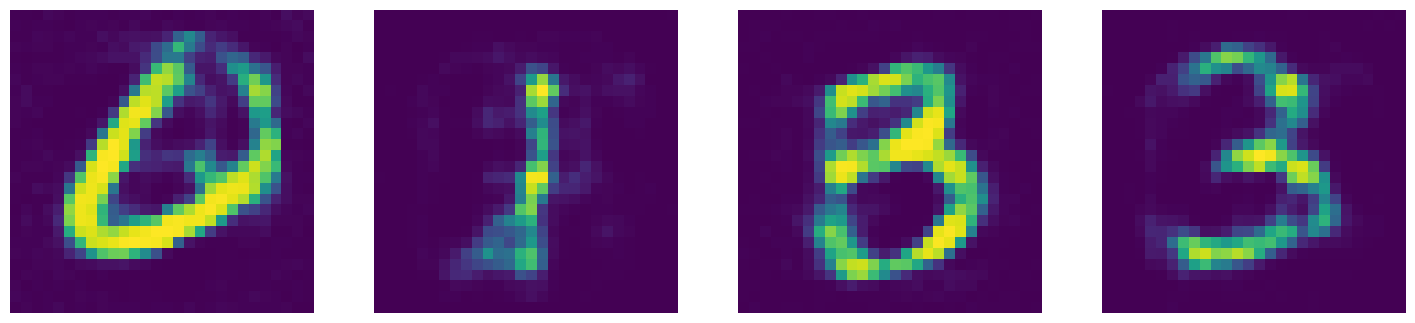

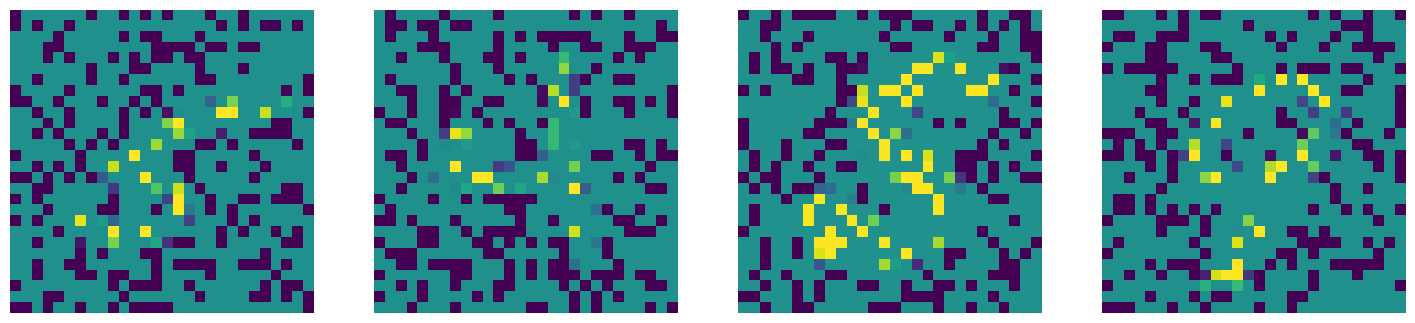

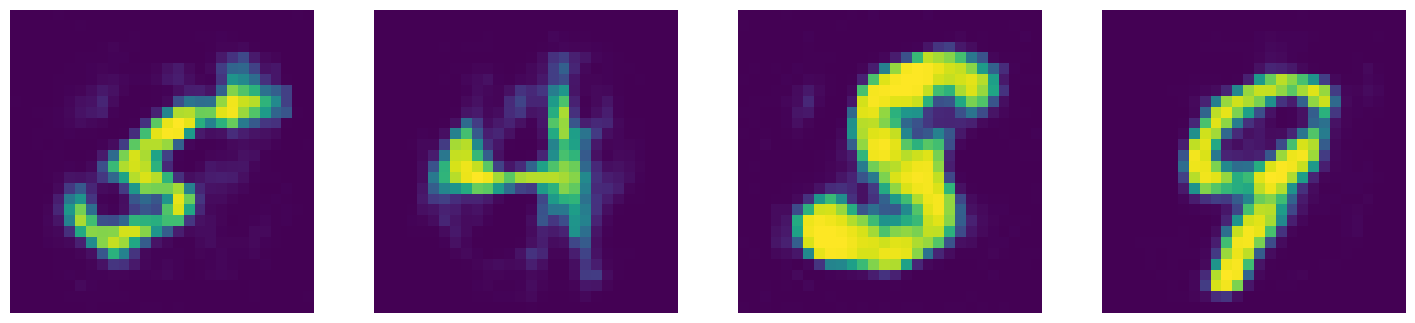

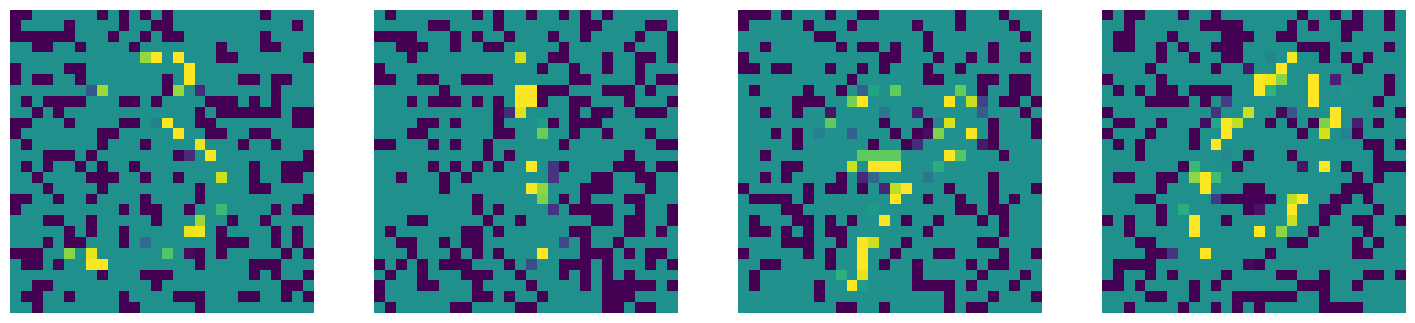

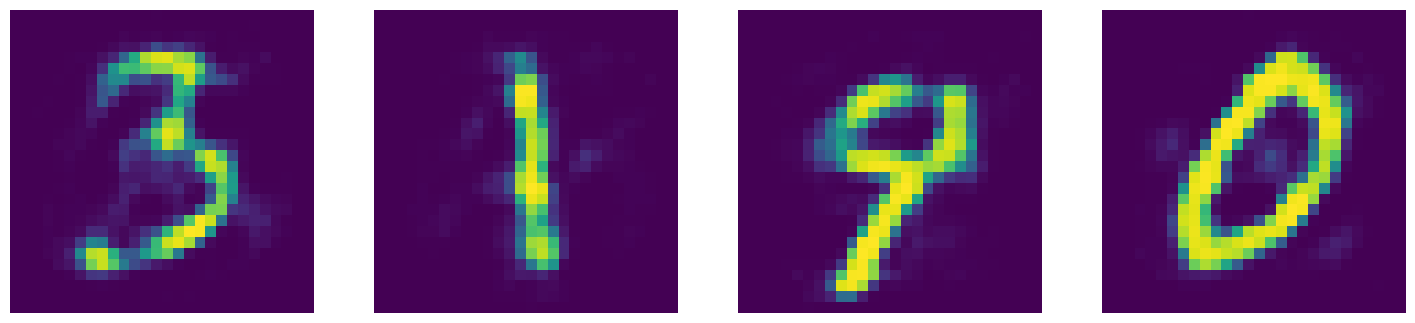

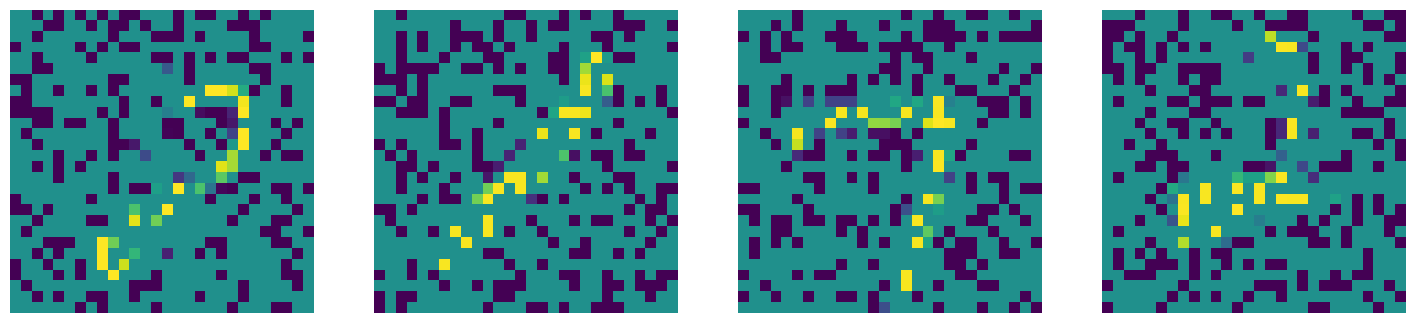

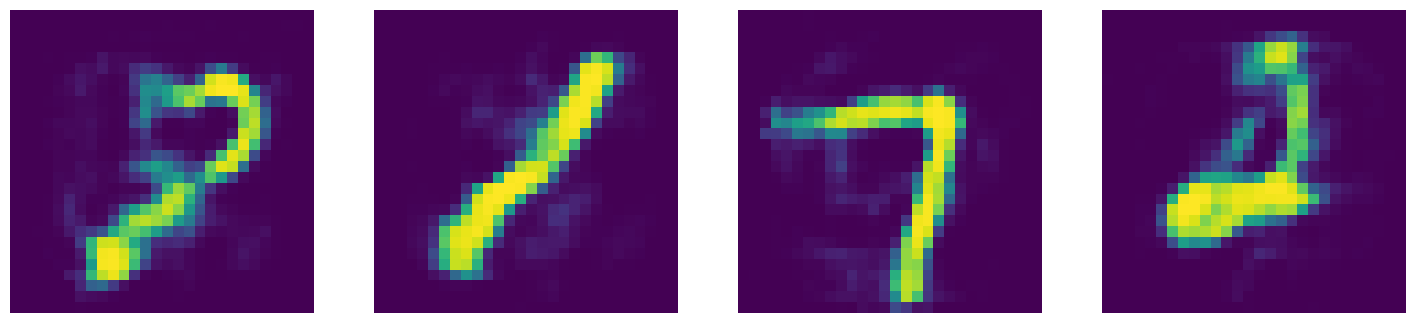

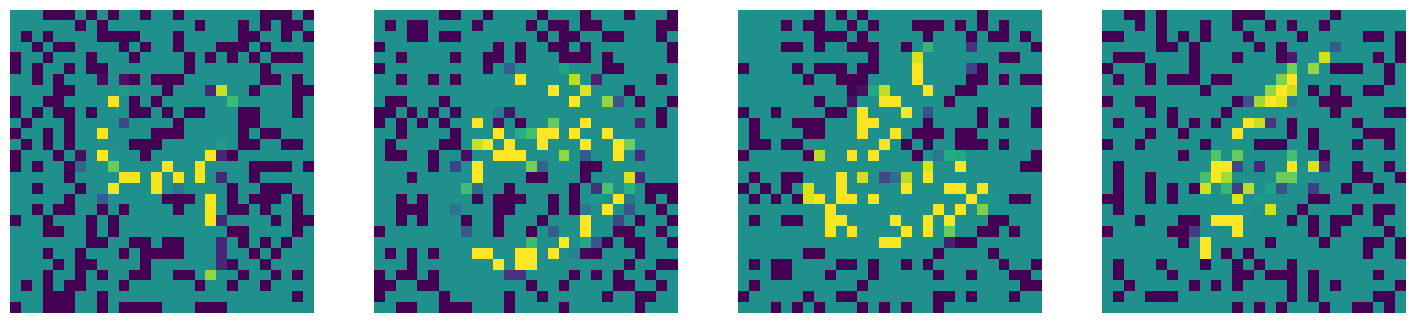

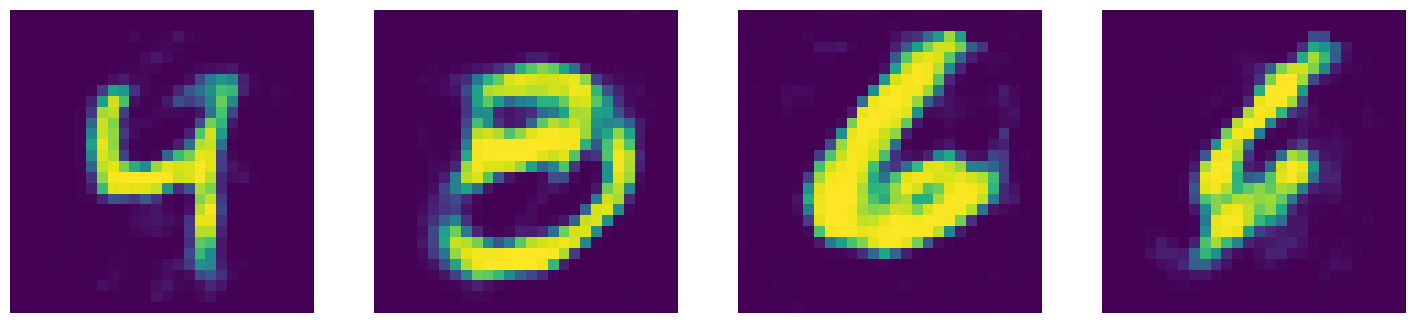

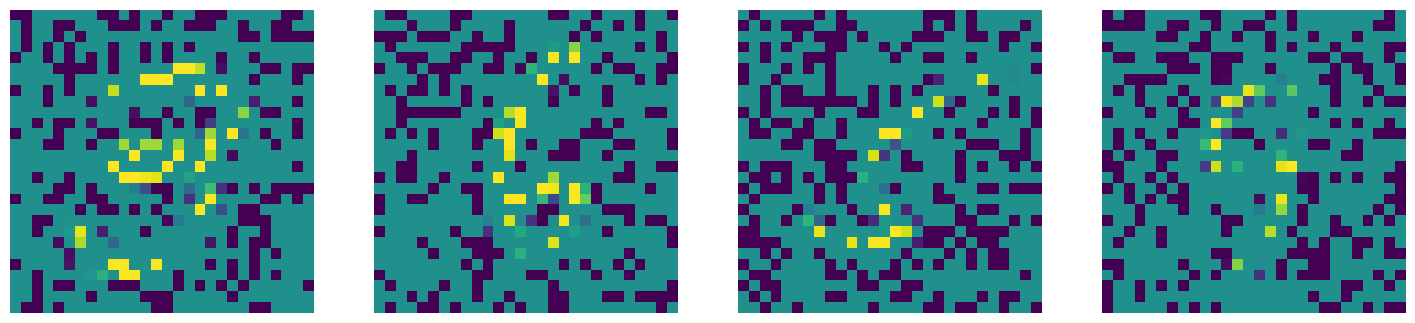

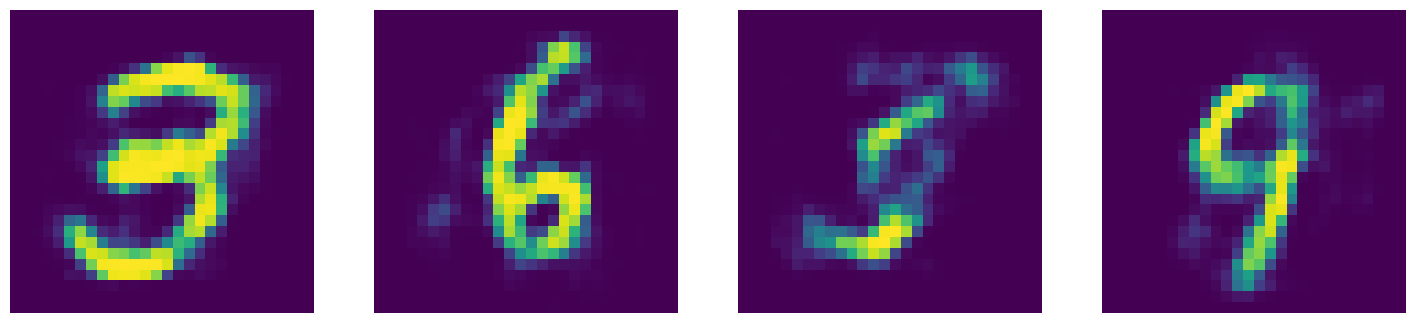

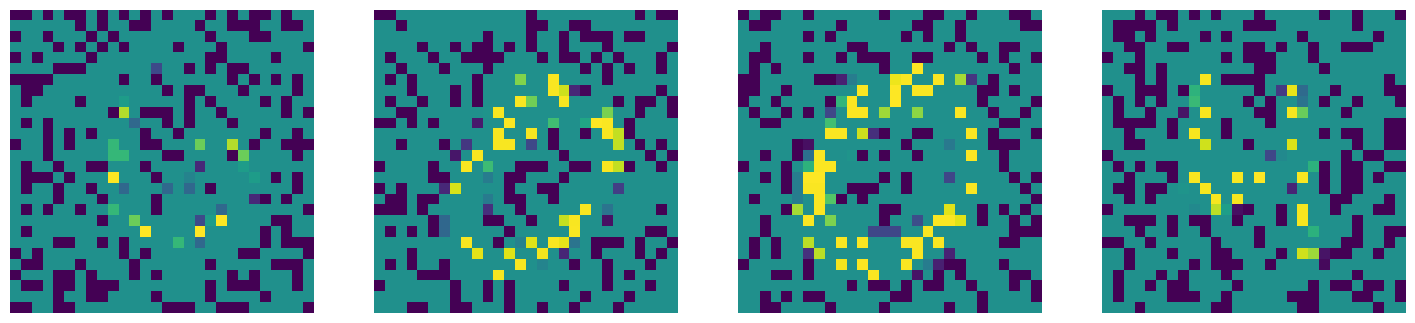

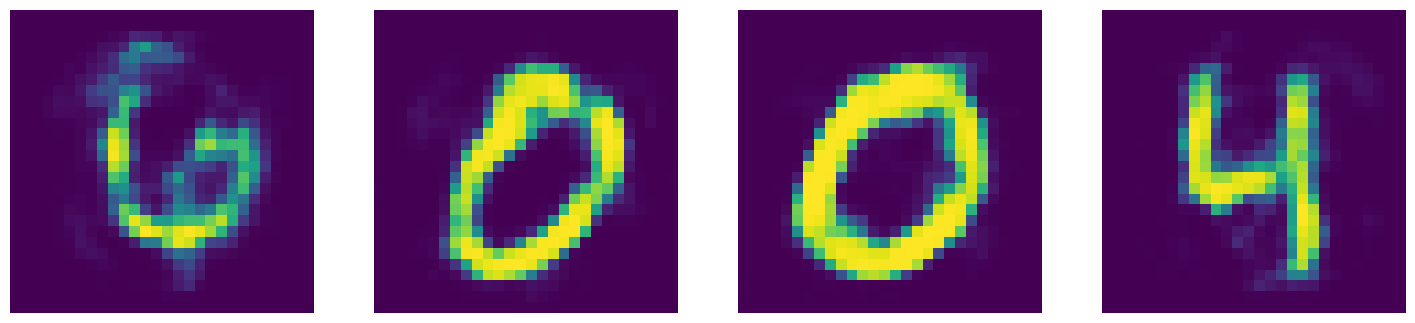

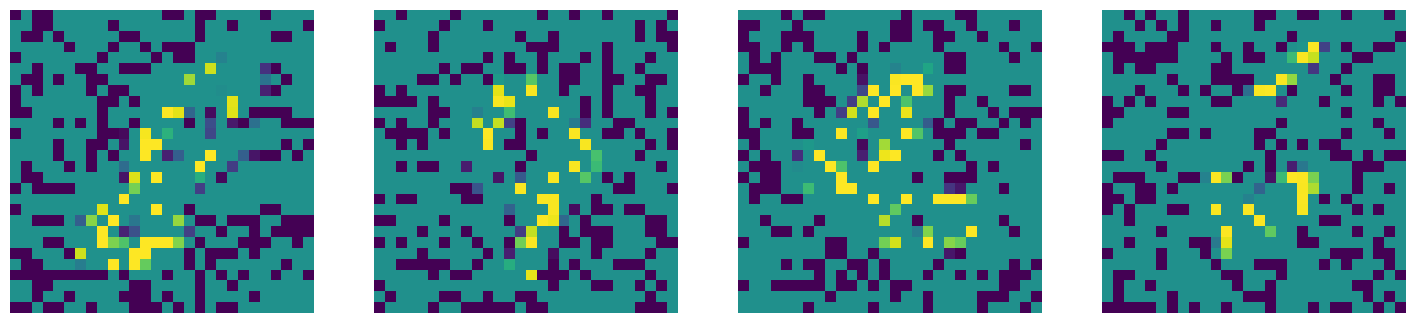

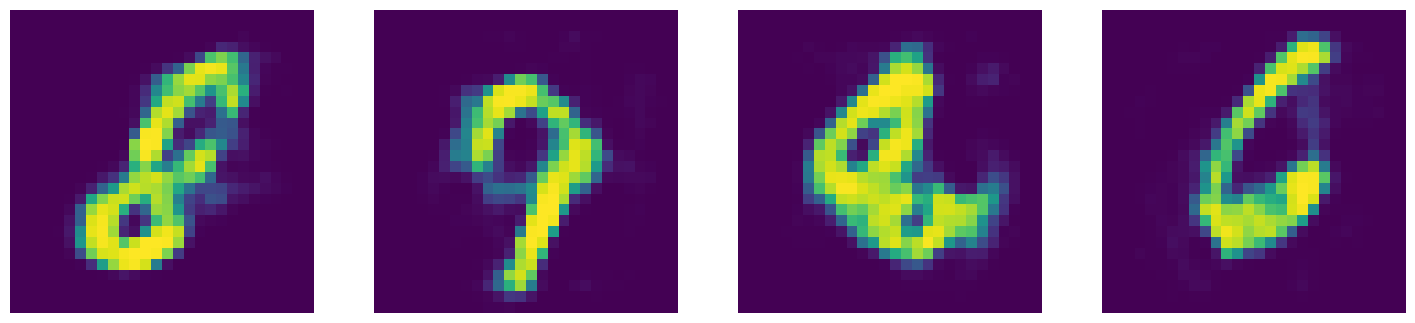

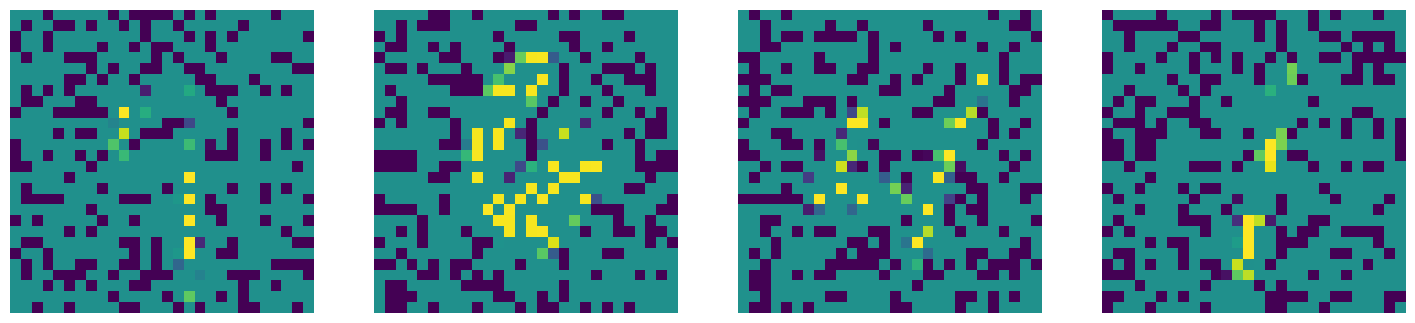

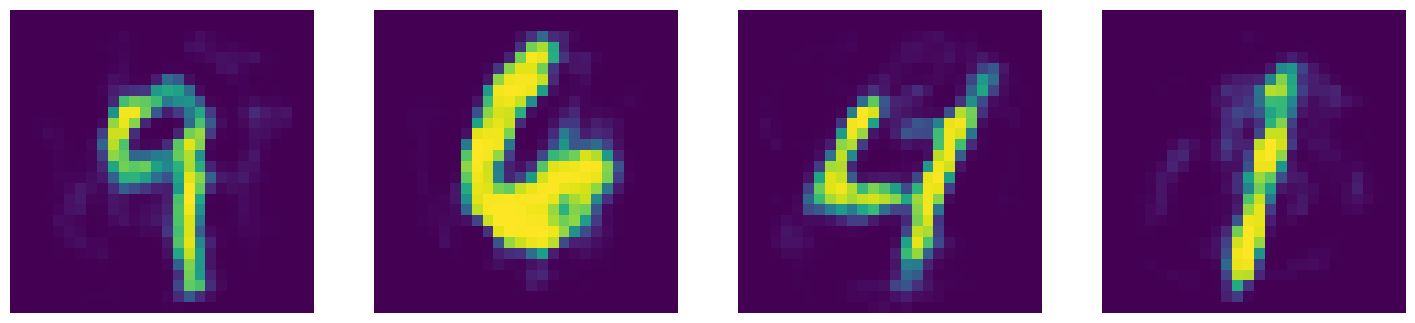

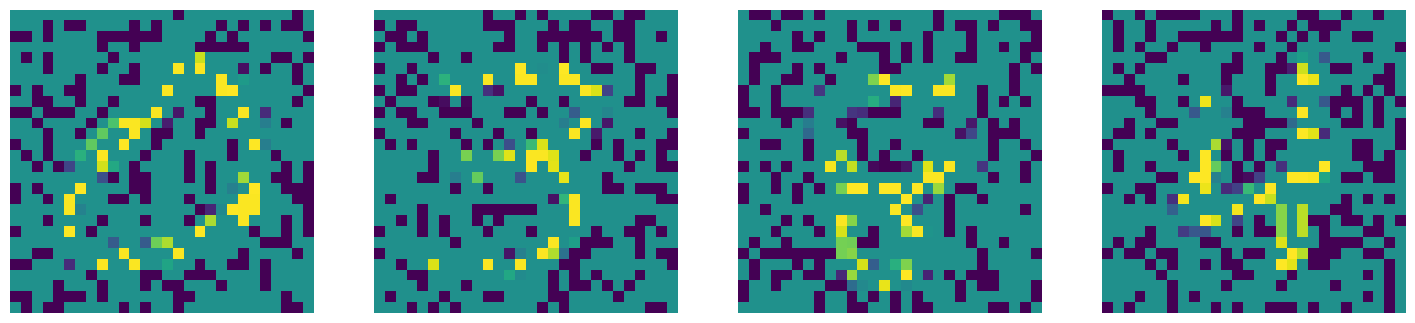

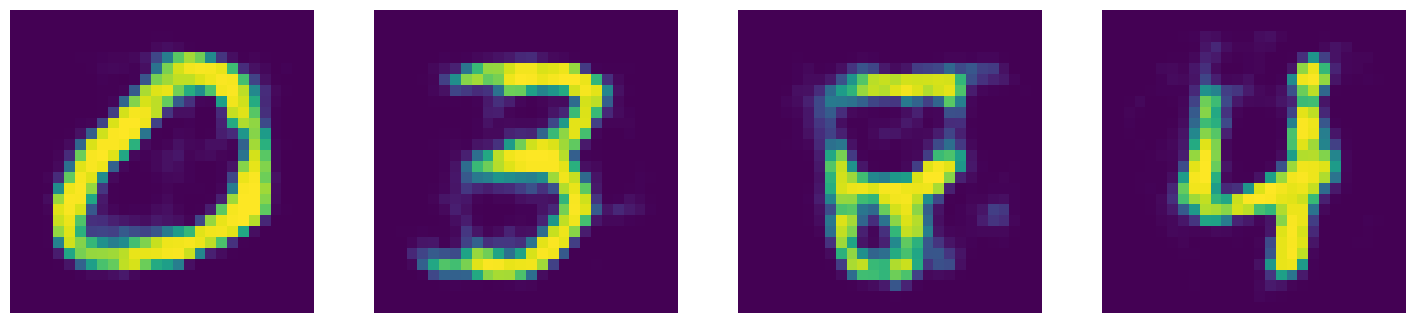

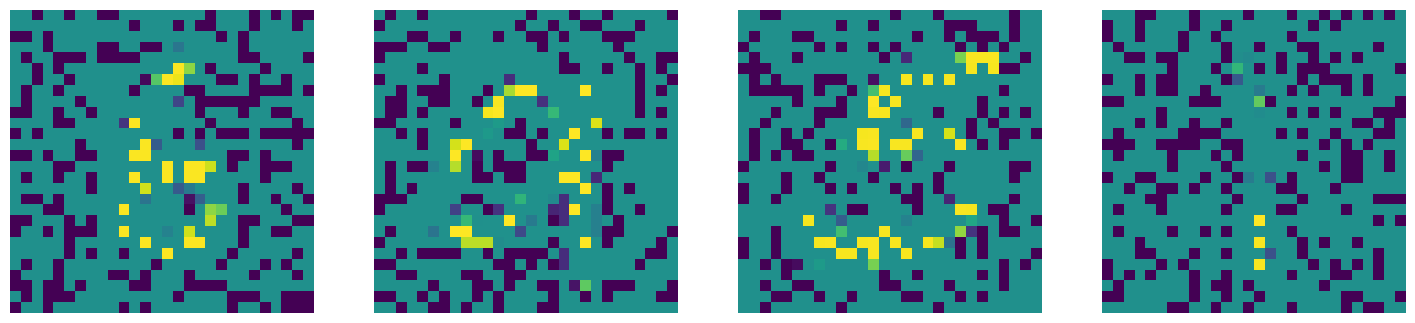

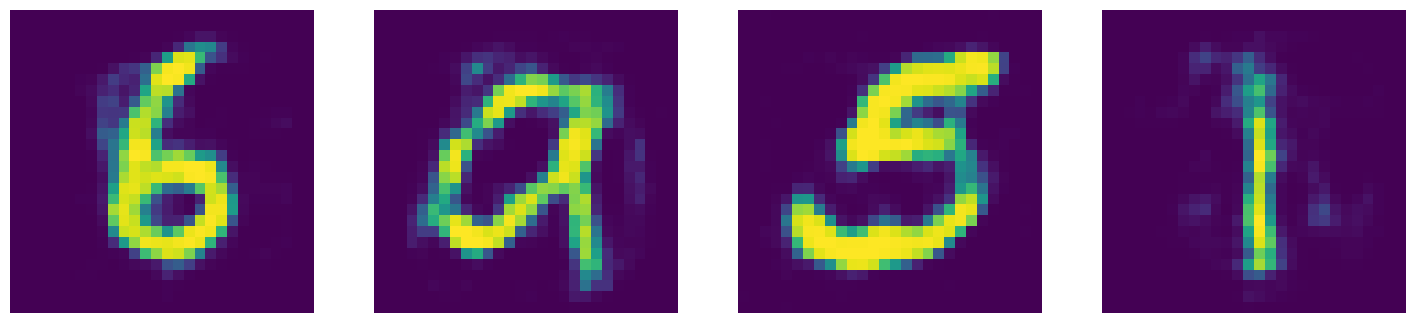

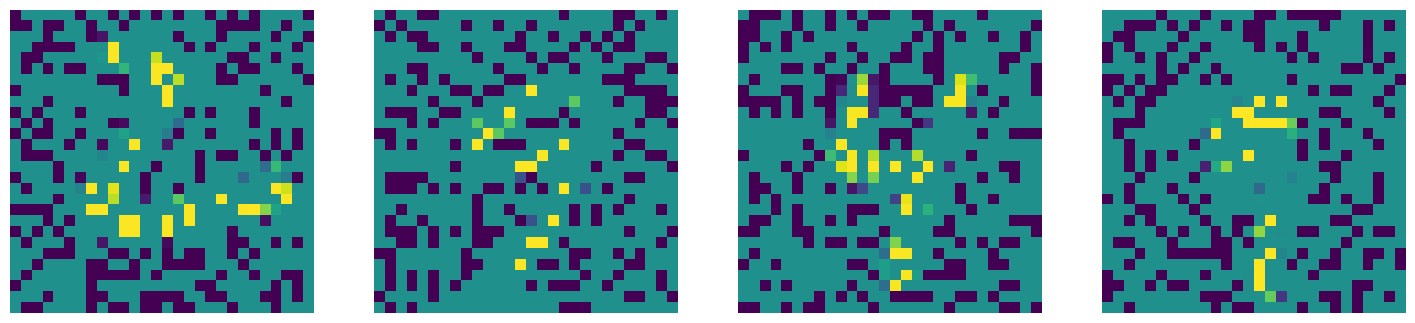

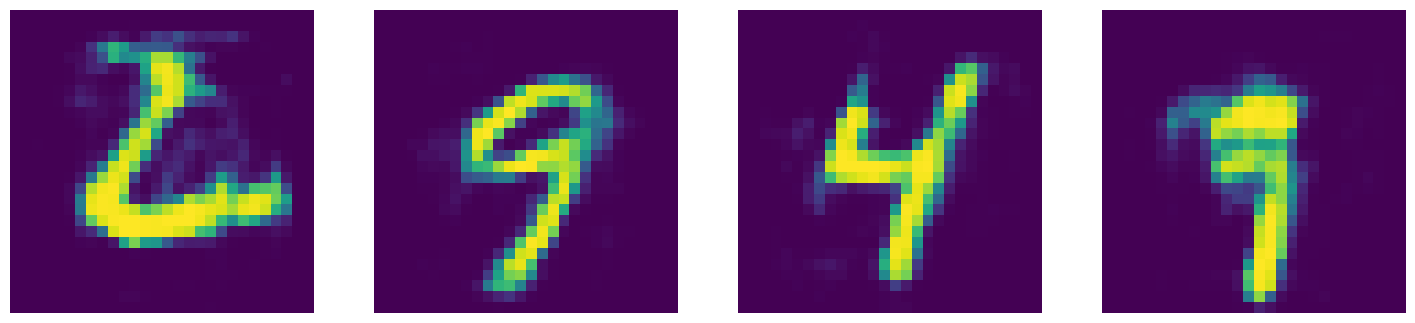

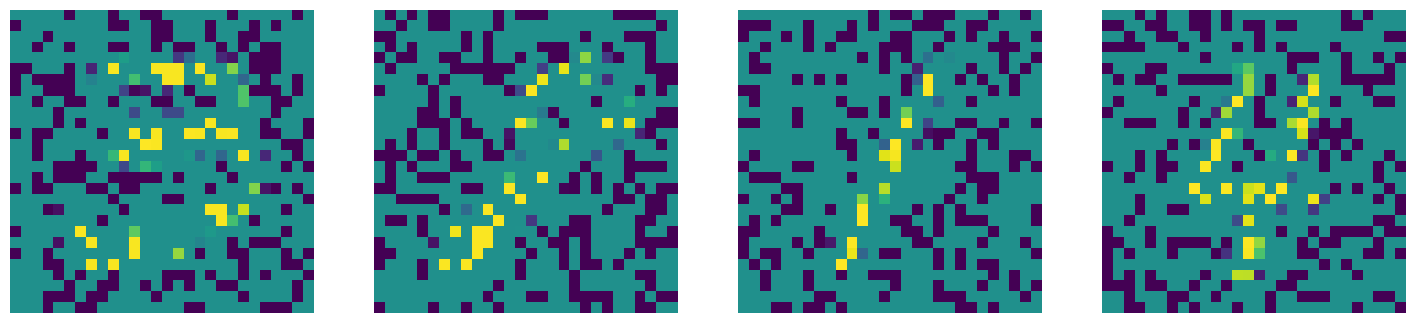

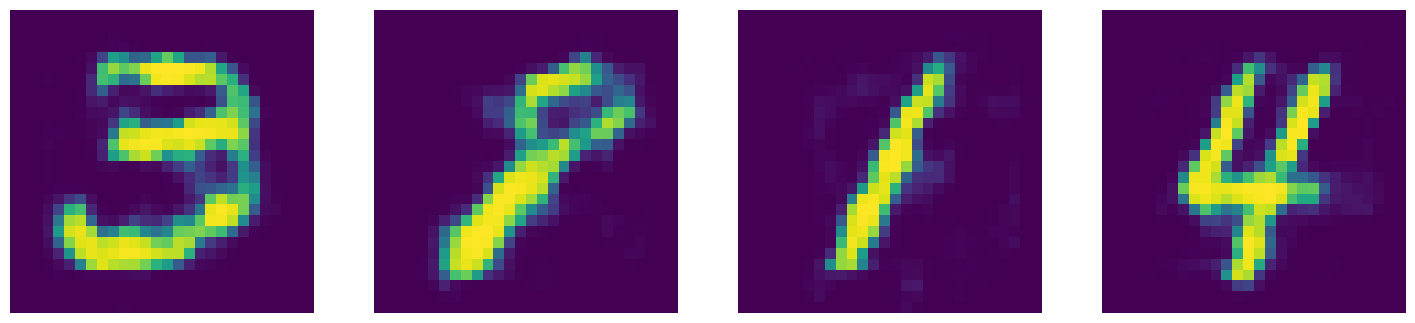

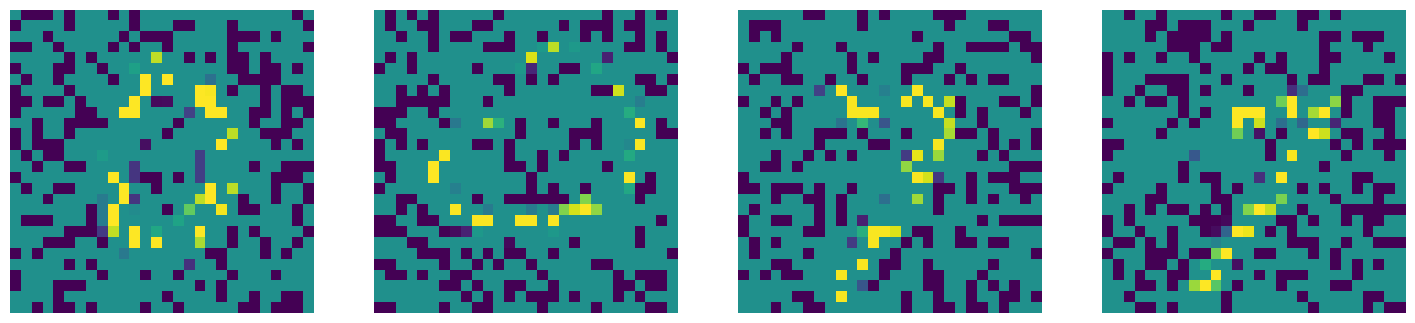

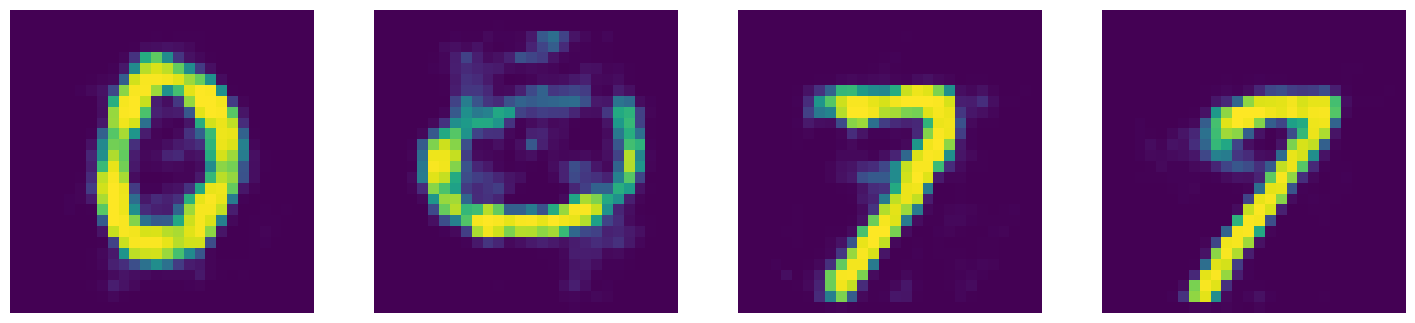

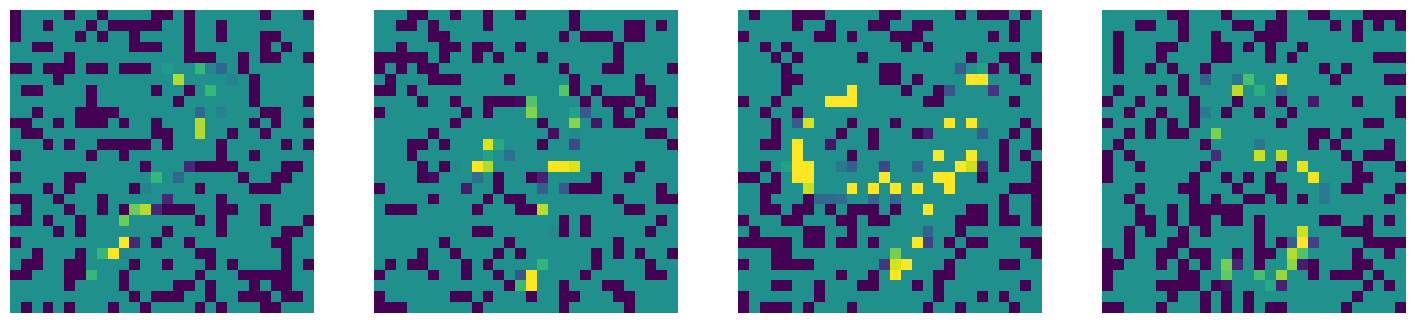

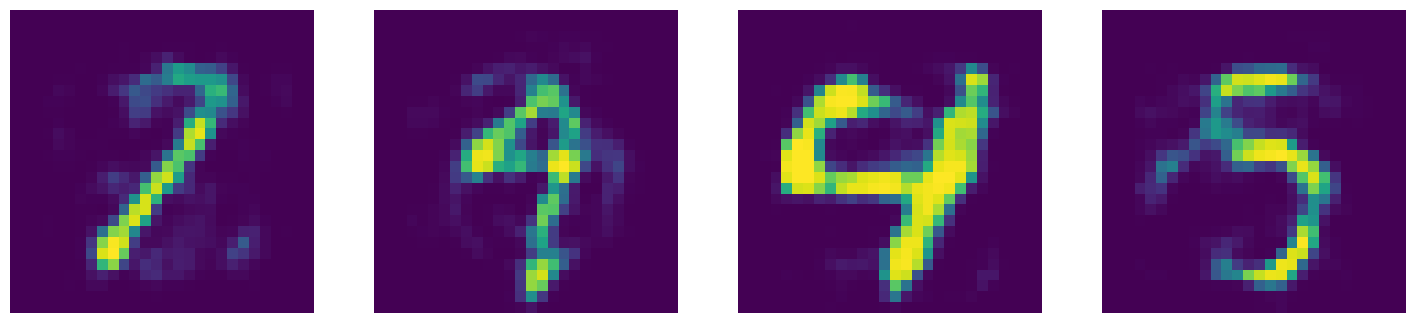

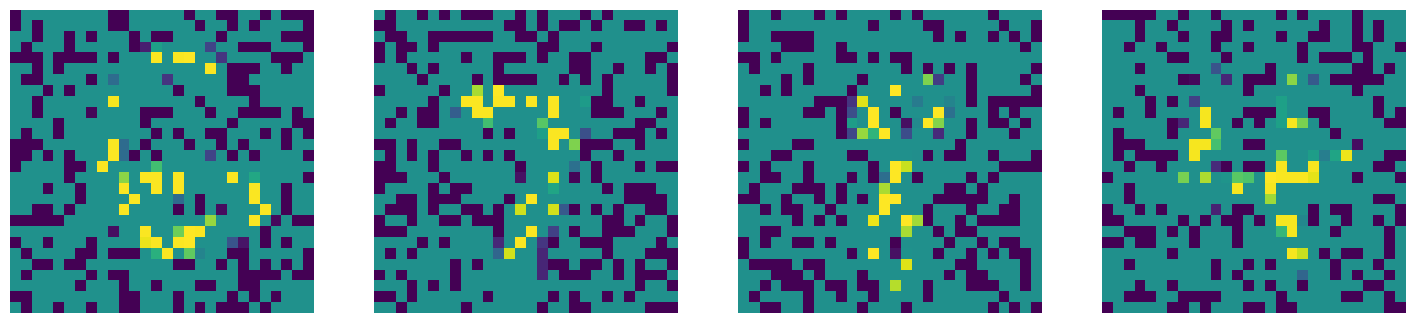

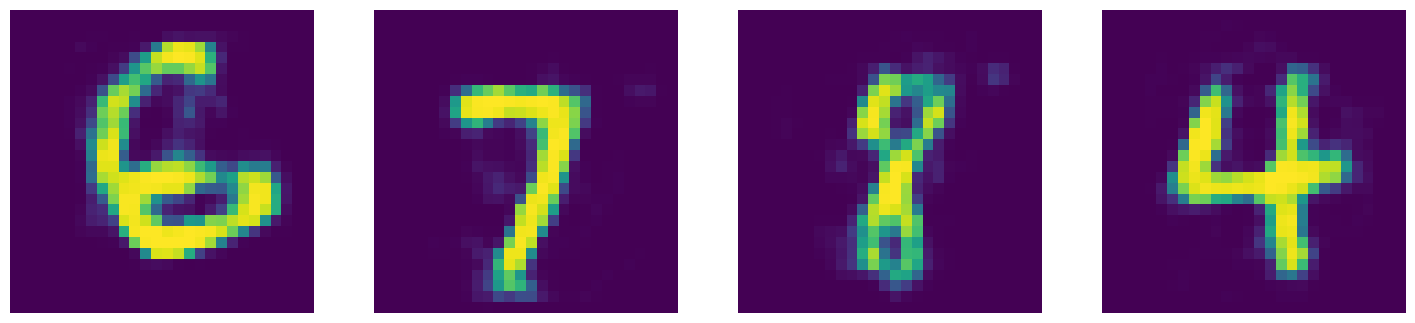

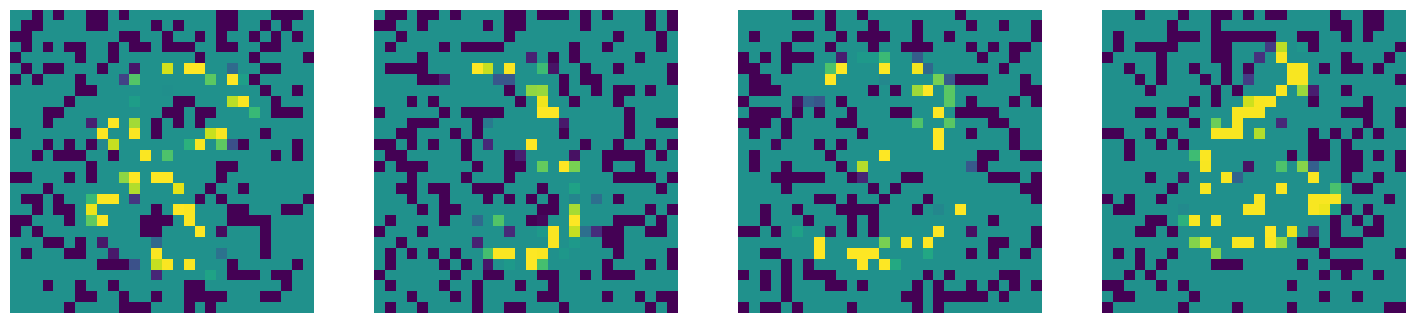

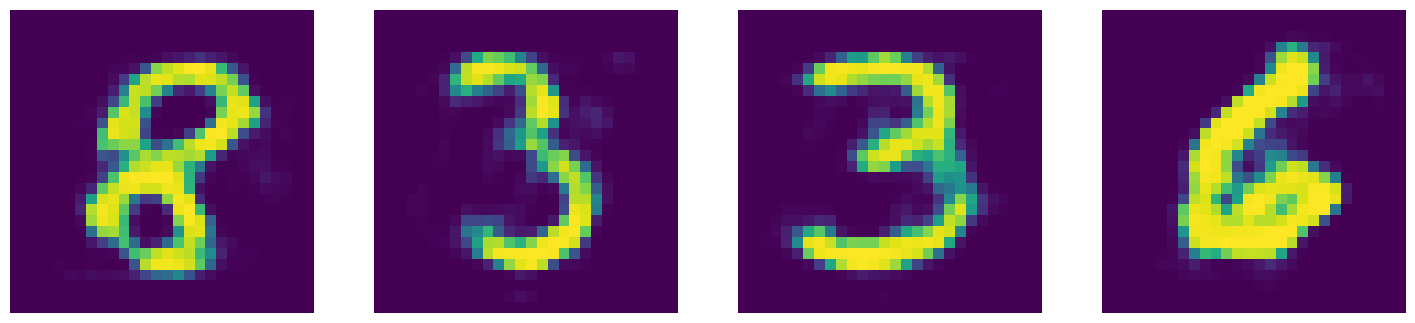

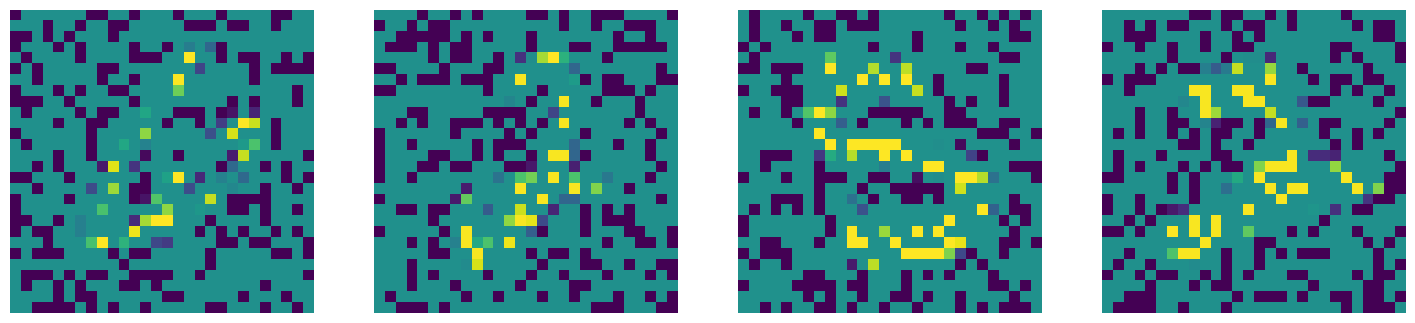

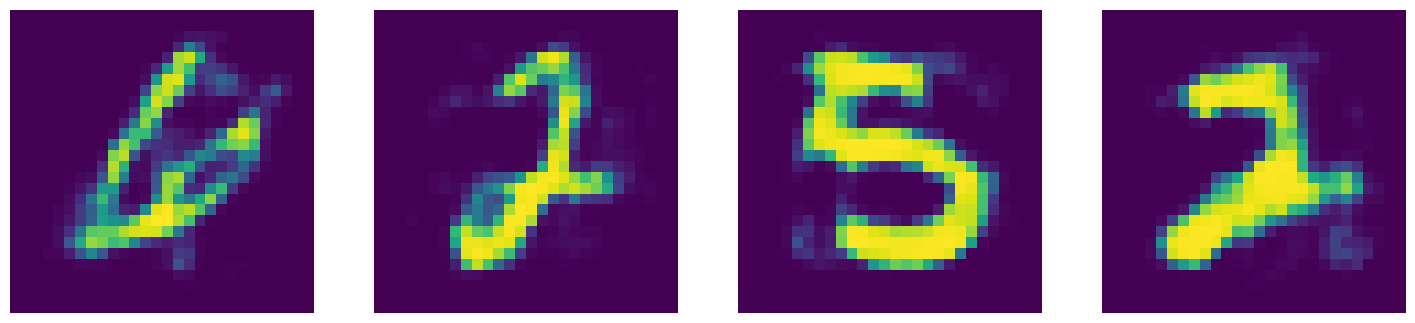

In [5]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 20
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1) # [batch_size, 28*28]
        # add noise
        noise = (torch.randn_like(img)>0.5).float().to(device)
        img_noise = (img * noise).to(device)
        # forward
        hidden,output = model(img_noise)
        loss = criterion(output, img)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_noise, output)
torch.save(model, './results/DAE.pth')

# 4. Compare the autoencoder inpainting capabilities vs. OpenCV


In [6]:
from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [7]:
img_bad = img_noise.detach().clone()
model = torch.load('./results/DAE.pth')

In [8]:
dst_TELEA = list()
dst_NS = list()

for i in range(0, 5):
    corrupted_img = ((img_bad.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 1 - noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

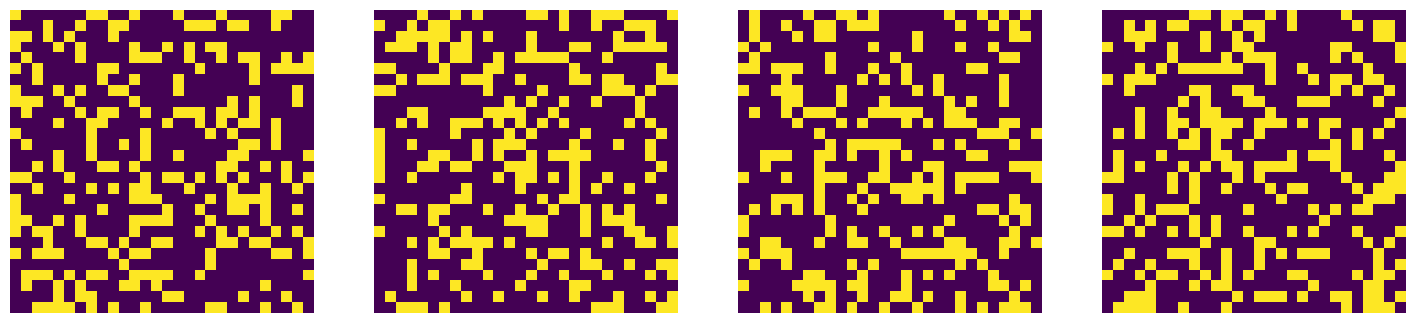

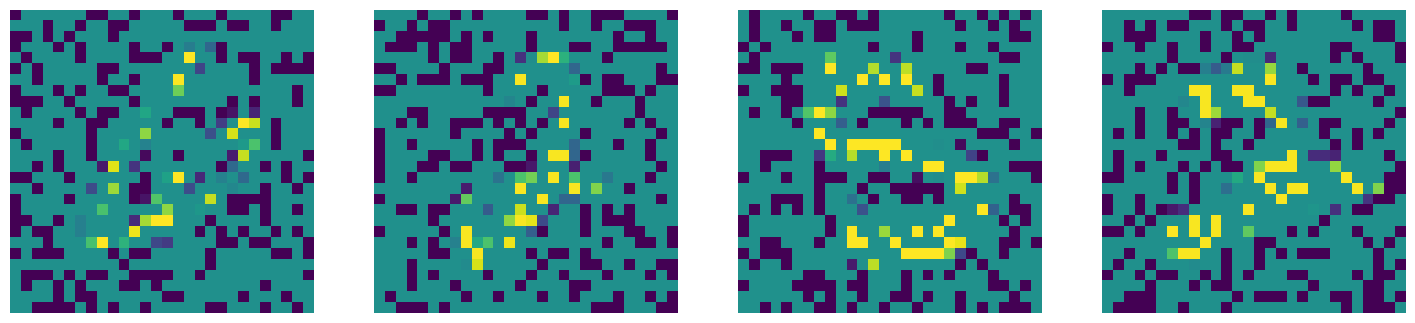

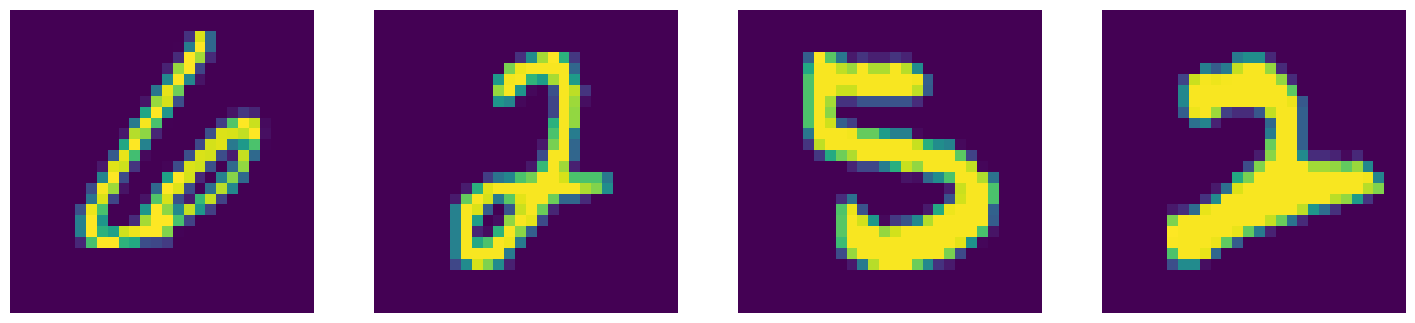

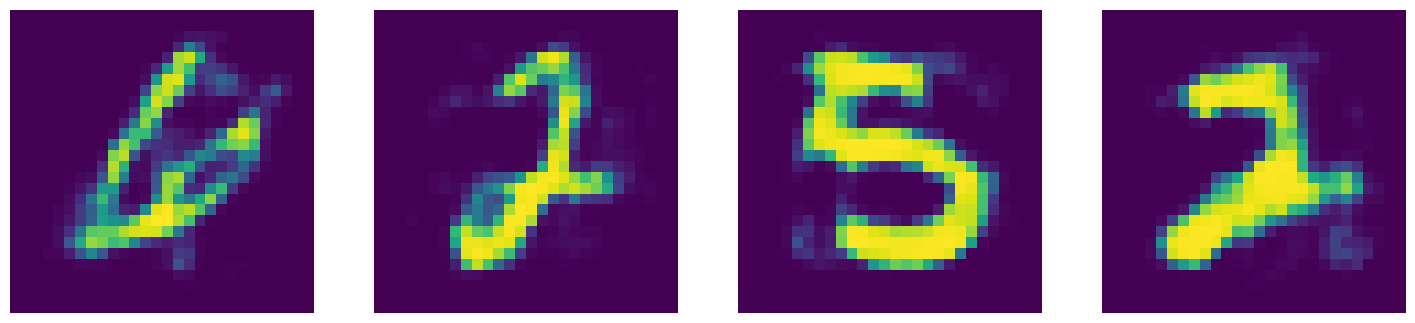

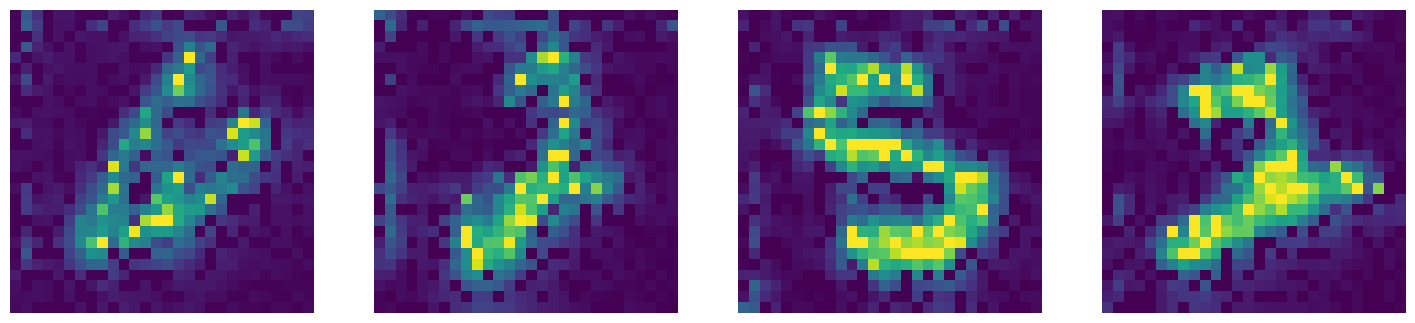

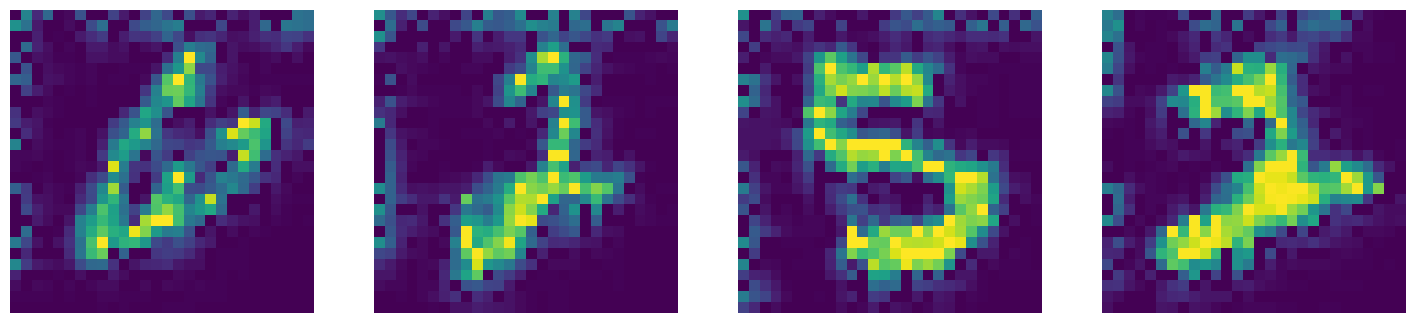

In [9]:
# Compare the results: 
# [noise], [img + noise], [img], [AE, Telea, Navier-Stokes] inpainting

with torch.no_grad():
    display_images(noise[0:5], img_bad[0:5])
    display_images(img[0:5], output[0:5])
    display_images(TELEA, NS)